In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
import scanpy as sc 
import sys 
sys.path.append('../../src')

from spaceoracle.prophets import Prophet

2025-01-19 13:16:07.168655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
adata = sc.read_h5ad(
    '/ix/djishnu/shared/djishnu_kor11/training_data/survey_kidney.h5ad')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

### Rerun CO if oracle object was not saved properly

In [6]:
sc.tl.pca(adata, svd_solver='arpack')
adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster_cat'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'imputed_count', 'normalized_count', 'npc-l1p', 'ra

In [7]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

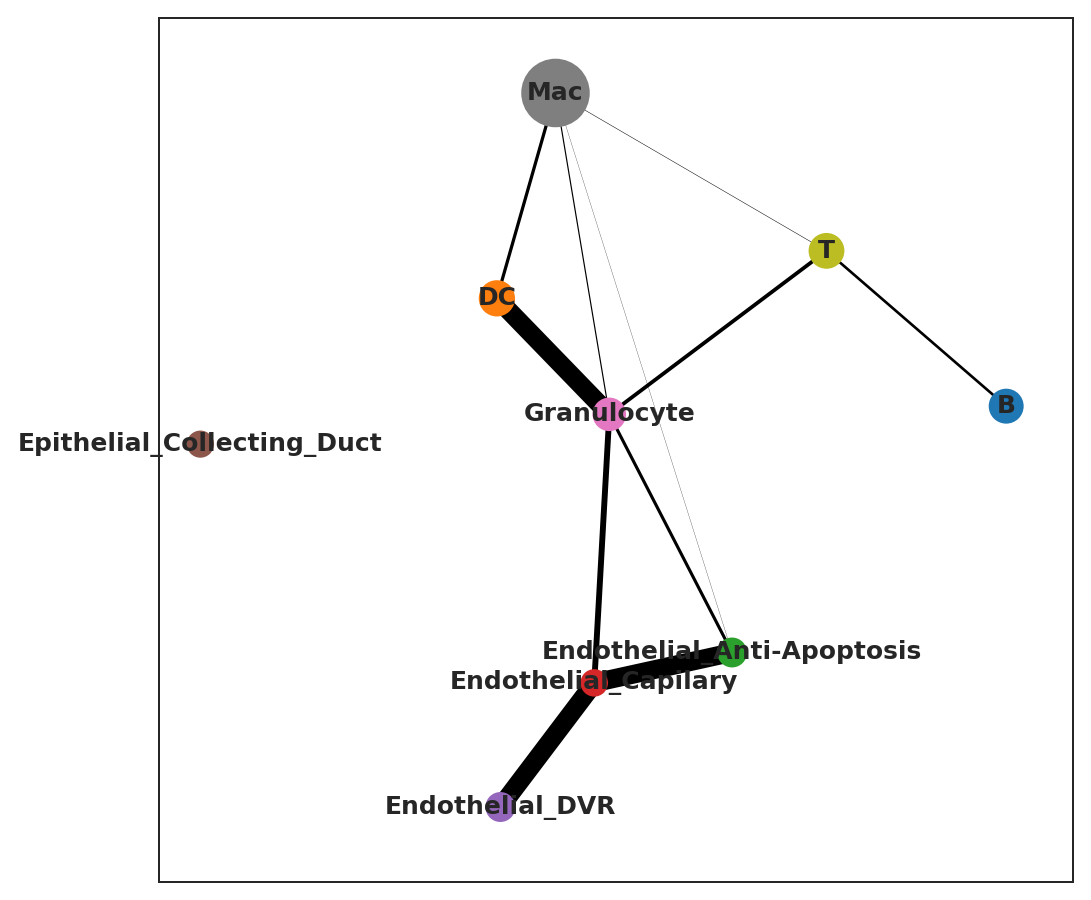

In [9]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='ct2')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

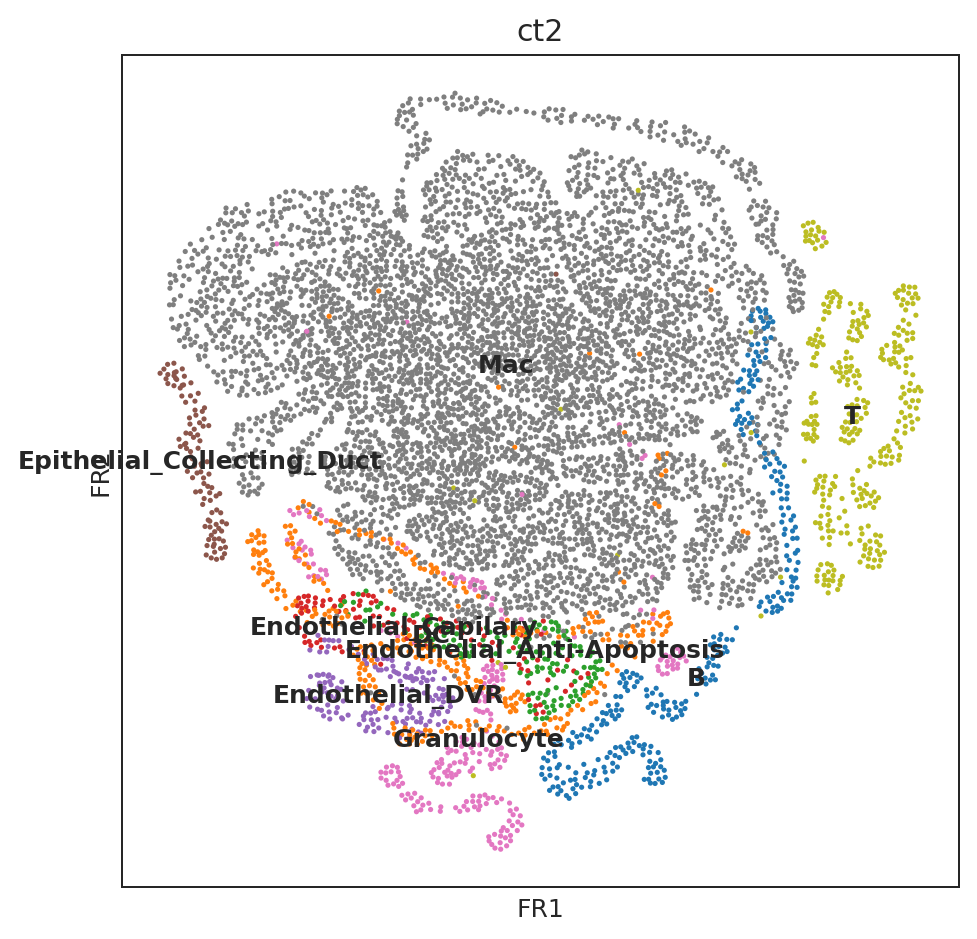

In [10]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='ct2', legend_loc='on data')

In [11]:
adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster_cat'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'diffmap_evals', 'paga', 'ct2_sizes', 'ct2_colors', 'draw_graph'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial', 'X_diffmap', 'X_dra

In [12]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()
oracle.import_anndata_as_raw_count(adata=adata.copy(),
                                   cluster_column_name="ct2",
                                   embedding_name="X_draw_graph_fr")

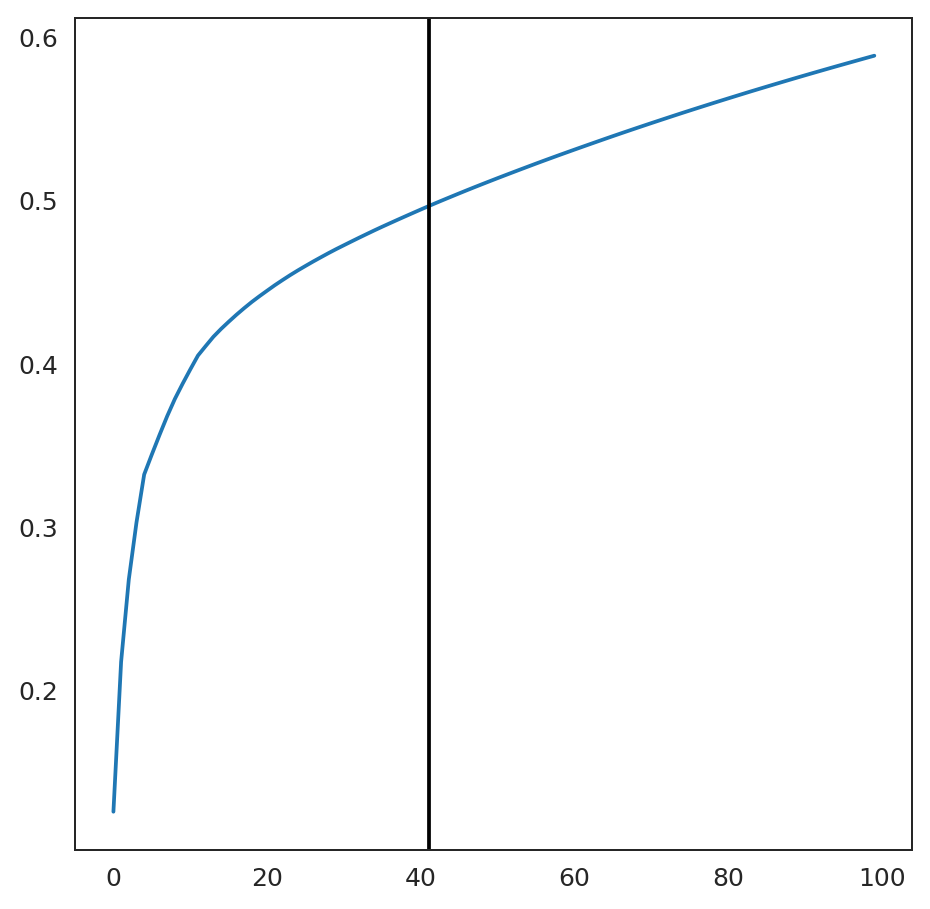

41


In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :6959
Auto-selected k is :173


In [19]:
# In order to use the same CO betas, we need to use the same imputation method

# oracle.knn_imputation(
#     n_pca_dims=n_comps, 
#     k=k, 
#     balanced=True, 
#     b_sight=k*8,
#     b_maxl=k*4, 
#     n_jobs=4
# )

oracle.adata.layers["imputed_count"] = adata.layers["imputed_count"].copy()
oracle.knn = True

In [16]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [20]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="ct2", alpha=10,
                         verbose_level=10)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for B...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for DC...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_Anti-Apoptosis...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_Capilary...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_DVR...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Epithelial_Collecting_Duct...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Granulocyte...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Mac...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for T...


  0%|          | 0/2295 [00:00<?, ?it/s]

CPU times: user 34min 9s, sys: 13 s, total: 34min 22s
Wall time: 48min 17s


In [21]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [22]:
outdir = '/ix/djishnu/shared/djishnu_kor11/co_outputs'
oracle.to_hdf5(f"{outdir}/survey_kidney.celloracle.oracle")
links.to_hdf5(file_path=f"{outdir}/survey_kidney.links.celloracle.links")

### Check transition method

In [ ]:
from spaceoracle.prophets import Prophet
from spaceoracle.judges import Judge

In [ ]:
pythia = Prophet(
    adata=adata,
    models_dir='/ix/djishnu/shared/djishnu_kor11/models_v2',
    annot='rctd_cluster',
    annot_labels='rctd_celltypes'
)

pythia.compute_betas()

In [ ]:
judger = Judge(adata)

st_sim_adata = judger.create_sim_adata(
    pythia.adata.layers['imputed_count'], 
    pythia.adata.layers['simulated_count']
)

In [ ]:
%%time
seacells_data = judger.get_macrostates(st_sim_adata)

### Compare CO results